In [4]:
from SpecReduction import SpecFunctions as sf
import numpy as np
import pandas as pd
import scipy
import scipy.optimize as opt
from scipy.optimize import curve_fit
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from aquarel import load_theme
# from tqdm.autonotebook import tqdm
# from rascal.calibrator import Calibrator
# from rascal.util import refine_peaks

In [5]:
theme = load_theme('arctic_dark')
theme.apply()

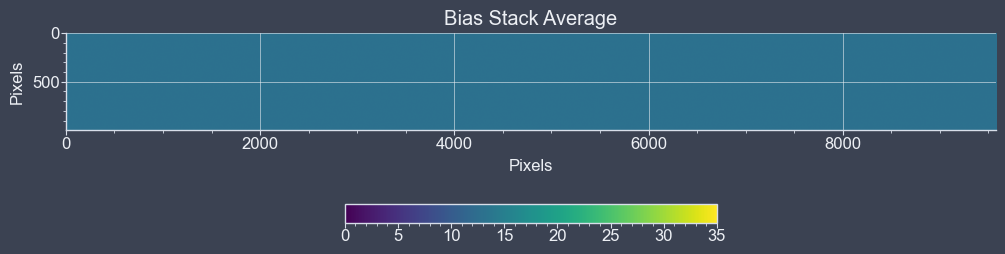

In [14]:
#median of full bias frames stack
bias_path = f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_'
bias_shape = fits.open(f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_0008.FIT')[0].data.shape
bias_avg = sf.median_img(100, bias_path, bias_shape[0], bias_shape[1])

plt.figure(figsize = (12,12))
plt.imshow(bias_avg)
plt.title('Bias Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

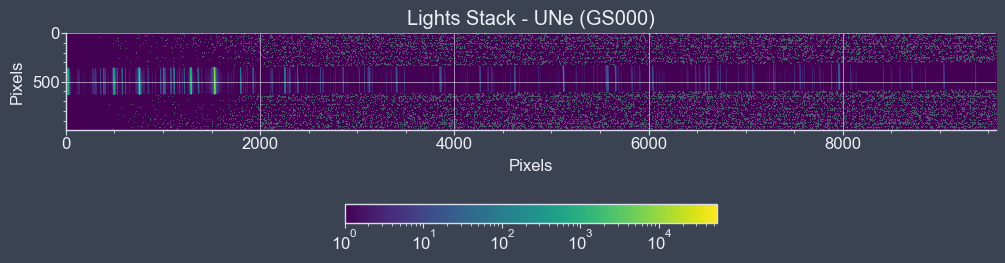

In [15]:
#median of full lights stack 
lights_path = f'Lab Day 20250729/UNe_unsaturated_lights/2025-07-29-2126_9-CapObj_'
lights_shape = fits.open(f'Lab Day 20250729/UNe_unsaturated_lights/2025-07-29-2126_9-CapObj_0012.FIT')[0].data.shape
lights_avg = sf.median_img(100,lights_path, lights_shape[0], lights_shape[1])

#subtract bias from lights
lights_avg = lights_avg - bias_avg

plt.figure(figsize = (12,12))
plt.imshow(lights_avg, norm = 'log')
plt.title('Lights Stack - UNe (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

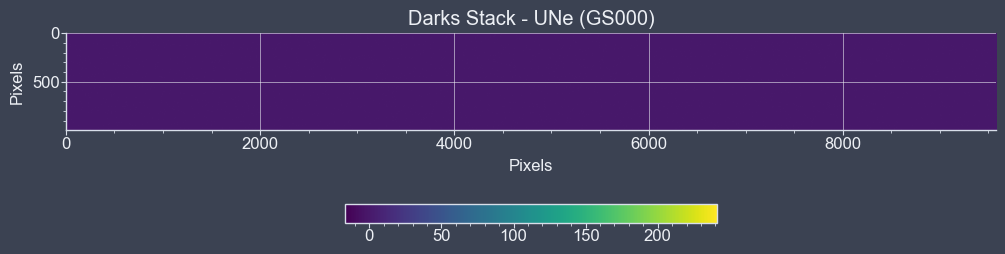

In [16]:
#median of darks stack
darks_path = f'Lab Day 20250729/UNe_unsaturated_darks/2025-07-29-2129_8-CapObj_'
darks_shape = fits.open(f'Lab Day 20250729/UNe_unsaturated_darks/2025-07-29-2129_8-CapObj_0011.FIT')[0].data.shape
darks_avg = sf.median_img(100,darks_path, darks_shape[0], darks_shape[1])

#subtract bias from darks
darks_avg = darks_avg - bias_avg

plt.figure(figsize = (12,12))
plt.imshow(darks_avg)
plt.title('Darks Stack - UNe (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()


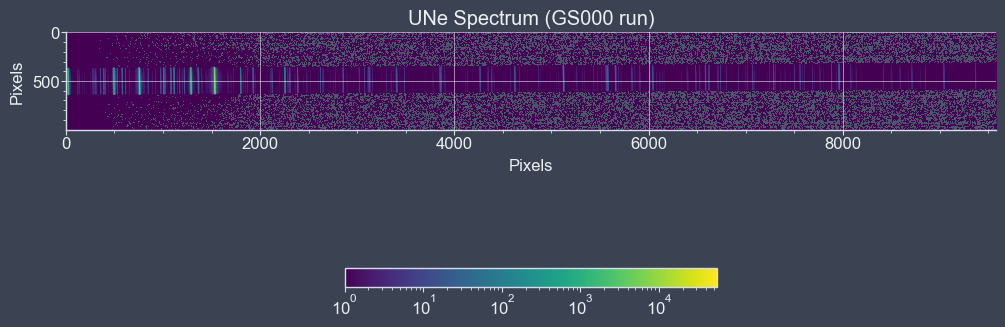

In [17]:
UNe_img = lights_avg - darks_avg

plt.figure(figsize = (12,12))
plt.imshow(UNe_img, norm = 'log')
plt.title('UNe Spectrum (GS000 run)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom')
plt.show()

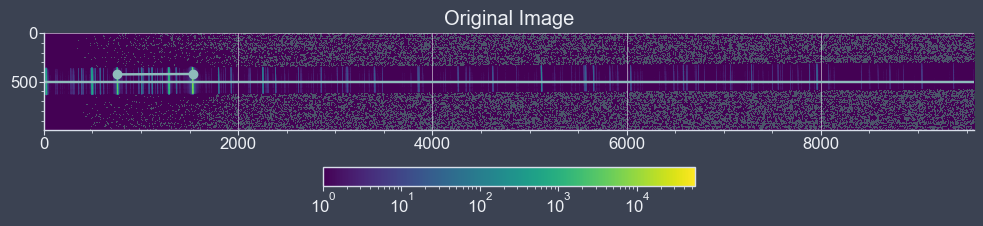

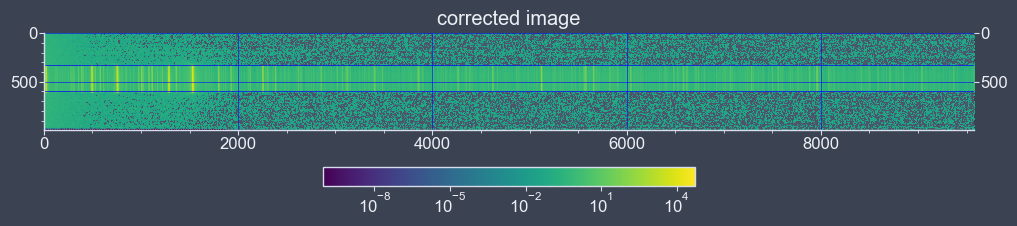

In [18]:
UNe_corrected = sf.straight_spec(UNe_img)

In [19]:
UNe_spec = sf.make1D(UNe_corrected)
UNe_spec = np.flipud(UNe_spec)

plt.figure(figsize = (6,4))
plt.plot(UNe_spec)
plt.title('1D UNe Spectrum')
plt.xlabel("x Pixels")
plt.ylabel("Normalized Flux")
plt.ylim(0,1)
plt.xlim(0, 9800)

(0.0, 9800.0)

In [20]:
peak_locs, peak_props = scipy.signal.find_peaks(UNe_spec, height = 0.005)
peak_vals = peak_props['peak_heights']
fwhm = scipy.signal.peak_widths(UNe_spec, peak_locs, rel_height = 0.5)[0]
fw = scipy.signal.peak_widths(UNe_spec, peak_locs, rel_height = 0.9)[0]


plt.figure(figsize = (6,4))
plt.plot(UNe_spec, label = 'spectrum')
plt.scatter(peak_locs, peak_vals, color = '#bf616a', label = 'peaks')
plt.legend()
plt.title('UNe Spectrum with Peaks')
plt.xlabel('x Pixel')
# plt.xlim(740, 800)
plt.ylabel('Normalized Flux')
print(fwhm)

[1.68577642 1.47276865 1.6820568  1.48020648 2.18734278 2.13989915
 1.6472258  1.76288909 2.38120028 2.65923157]


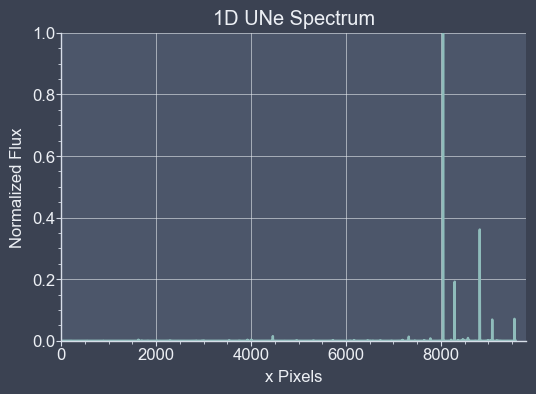

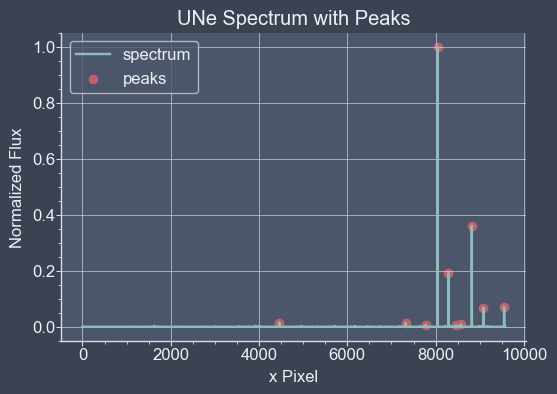

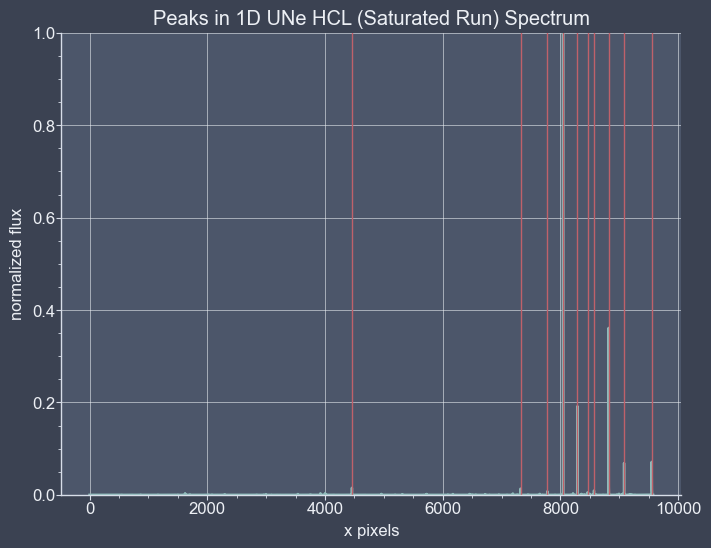

In [21]:
pixels = np.linspace(0, UNe_spec.size, UNe_spec.size +1)
x_center = np.array([])
for x in range(peak_locs.size):
    min_loc = int(np.floor(peak_locs[x] - fwhm[x]))
    # print(min_loc)
    max_loc = int(np.ceil(peak_locs[x] + fwhm[x]))
    # print(max_loc)
    loc_range = pixels[min_loc:max_loc]
    i_range = UNe_spec[min_loc:max_loc]
    num = 0
    for y in range(loc_range.size):
        num += loc_range[y]*i_range[y]
       
    x_center = np.append(x_center, num/np.sum(i_range))
    
plt.figure(figsize = (8,6))
plt.plot(UNe_spec, label = 'spectrum') #plots original data
for x in range(x_center.size):
    plt.axvline(x_center[x], color = '#bf616a', lw = 1) #plots peaks identified above

plt.xlabel('x pixels')
plt.ylabel('normalized flux')
plt.title('Peaks in 1D UNe HCL (Saturated Run) Spectrum')
plt.ylim(0, 1)
# plt.xlim(1000,1500)
plt.show()

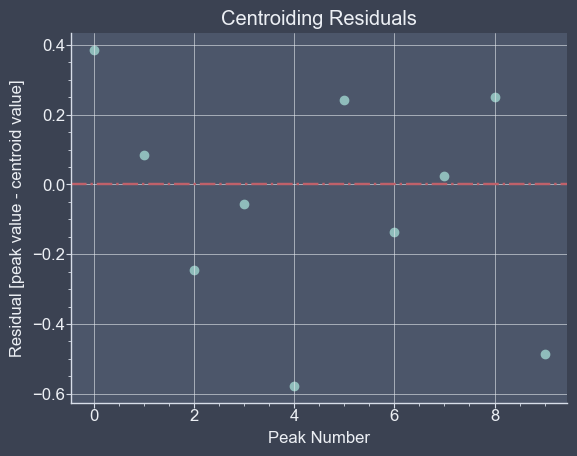

In [22]:
residuals = np.array([])
for p in range(peak_locs.size):
    residual = peak_locs[p] - x_center[p]
    residuals = np.append(residuals, residual)

plt.scatter(np.arange(len(residuals)),residuals)
plt.title('Centroiding Residuals')
plt.xlabel('Peak Number')
plt.ylabel('Residual [peak value - centroid value]')
plt.axhline(0,ls='-.', c = '#bf616a')
plt.show()

In [2]:
c = Calibrator(peak_locs, UNe_spec)
c.set_calibrator_properties(num_pix=len(UNe_spec))
c.plot_arc()

NameError: name 'Calibrator' is not defined

In [3]:
Ne_lines = np.genfromtxt('Ne_lines.csv', delimiter = ',')
Ne_intense = Ne_lines[1]
Ne_wavelengths = Ne_lines[0]

NameError: name 'np' is not defined

In [1]:
c.set_hough_properties(min_wavelength = 4800, max_wavelength = 6000, range_tolerance = 200)
c.set_ransac_properties(sample_size = 5, top_n_candidate = 7)
# c.clear_atlas()
# c.add_user_atlas('Ne', Ne_wavelengths, intensities=Ne_intense)
c.add_atlas(['Ne'], min_intensity = 10000)
c.do_hough_transform()
fit = c.fit()
fit_coeff = fit[0]
rms = fit[3]
residuals = fit[4]
peak_util = fit[5]
c.plot_fit(fit_coeff, spectrum = UNe_spec, display = True)
# print(fit)

NameError: name 'c' is not defined